In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import random
import csv
import math
from sklearn import metrics
import h2o
from h2o.automl import H2OAutoML


random.seed(24)
np.random.seed(seed=24)
set_label = 2000

# s3://vault-data-corpus/vessel data/H2O Generated Data/
main = '/Users/kimmontgomery/Documents/POC_DOD/DOD4/'
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 38 mins
H2O_cluster_timezone:,America/Denver
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.0.5216
H2O_cluster_version_age:,2 months and 25 days
H2O_cluster_name:,H2O_from_python_kimmontgomery_obdaca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.942 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [13]:

train = h2o.import_file(main + "train_with_features.csv")
test = h2o.import_file(main + "test_with_features.csv")

#train['target']= train.apply(lambda row: int((row['distance_from_predicted'] > 10.0) and (row['distance_from_previous'] > 10.0)), axis=1)

# If the columns corresponding to the point being predicted are still present, drop them
drop_columns =  ['X_5', 'Y_5', 'Z_5', 'SOG_5', 'COG_5', 'Heading_5', 'ROT_5', 'BaseDateTime_5', 
                 'Status_5', 'VoyageID_5', 'MMSI_5', 'ReceiverType_5', 'ReceiverID_5', 'dataset_5',
                 'time_gap_5', 'predicted_x', 'predicted_y']

# Drop these columns if still present
drop_columns += ['distance_from_predicted', 'distance_from_previous']
drop_columns += ['Z_1', 'Z_2', 'Z_3', 'Z_4']
drop_columns += [ 'dataset_2', 'dataset_3','dataset_4']
drop_columns += ['BaseDateTime_1', 'BaseDateTime_2',  'BaseDateTime_3',  'BaseDateTime_4']

train_columns = list(train.columns)

keep_columns = [item for item in train_columns if item not in drop_columns]

# Identify predictors and response
x = keep_columns
y = "target"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
# Run AutoML for up to an hour
aml = H2OAutoML(max_runtime_secs=3600, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20210102_223301,0.809324,0.177293,0.26174,0.34006,0.213802,0.0457112
StackedEnsemble_AllModels_AutoML_20210102_223301,0.809271,0.177735,0.257077,0.348198,0.214216,0.0458885
GBM_grid__1_AutoML_20210102_223301_model_3,0.79976,0.175524,0.23995,0.328774,0.213855,0.045734
GBM_grid__1_AutoML_20210102_223301_model_5,0.798104,0.177718,0.250494,0.342229,0.213564,0.0456096
GBM_5_AutoML_20210102_223301,0.797257,0.177034,0.229998,0.346558,0.214711,0.0461007
XGBoost_grid__1_AutoML_20210102_223301_model_5,0.797253,0.178279,0.23262,0.350224,0.215399,0.0463968
GBM_4_AutoML_20210102_223301,0.79485,0.181075,0.232912,0.350313,0.21558,0.0464747
GBM_grid__1_AutoML_20210102_223301_model_10,0.793978,0.177283,0.241694,0.367089,0.21412,0.0458476
XGBoost_grid__1_AutoML_20210102_223301_model_28,0.793922,0.176663,0.231948,0.352608,0.214384,0.0459604
GBM_2_AutoML_20210102_223301,0.793805,0.178737,0.237917,0.358027,0.215069,0.0462546


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
StackedEnsemble_BestOfFamily_AutoML_20210102_223301,0.809324,0.177293,0.26174,0.34006,0.213802,0.0457112,603,0.045356
StackedEnsemble_AllModels_AutoML_20210102_223301,0.809271,0.177735,0.257077,0.348198,0.214216,0.0458885,1579,0.120422
GBM_grid__1_AutoML_20210102_223301_model_3,0.79976,0.175524,0.23995,0.328774,0.213855,0.045734,950,0.004885
GBM_grid__1_AutoML_20210102_223301_model_5,0.798104,0.177718,0.250494,0.342229,0.213564,0.0456096,1116,0.004113
GBM_5_AutoML_20210102_223301,0.797257,0.177034,0.229998,0.346558,0.214711,0.0461007,1101,0.003736
XGBoost_grid__1_AutoML_20210102_223301_model_5,0.797253,0.178279,0.23262,0.350224,0.215399,0.0463968,1640,0.001672
GBM_4_AutoML_20210102_223301,0.79485,0.181075,0.232912,0.350313,0.21558,0.0464747,1014,0.003398
GBM_grid__1_AutoML_20210102_223301_model_10,0.793978,0.177283,0.241694,0.367089,0.21412,0.0458476,608,0.002942
XGBoost_grid__1_AutoML_20210102_223301_model_28,0.793922,0.176663,0.231948,0.352608,0.214384,0.0459604,2727,0.001648
GBM_2_AutoML_20210102_223301,0.793805,0.178737,0.237917,0.358027,0.215069,0.0462546,688,0.002997


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210102_223301


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2198812898218783: 


,,0,1,Error,Rate
0,0,8091.0,22.0,0.0027,(22.0/8113.0)
1,1,17.0,445.0,0.0368,(17.0/462.0)
2,Total,8108.0,467.0,0.0045,(39.0/8575.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

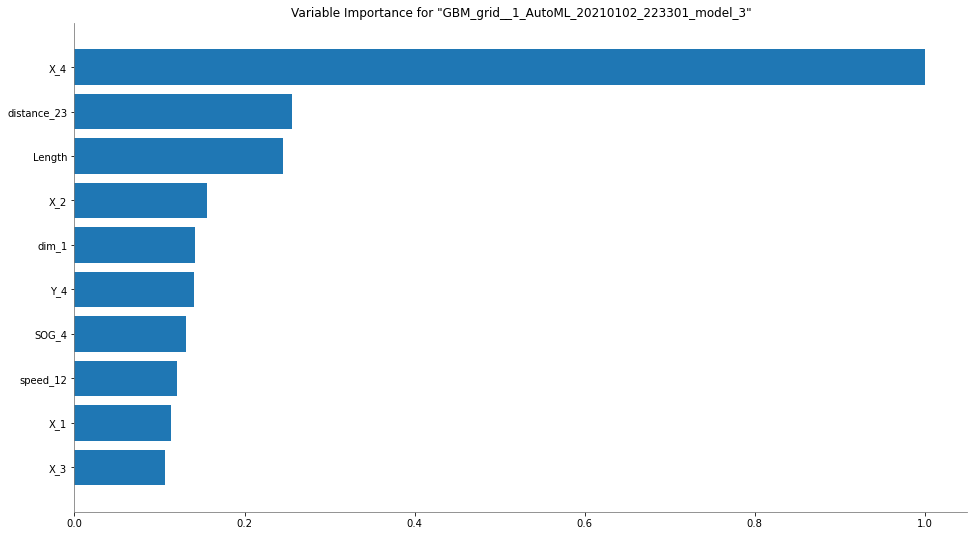

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

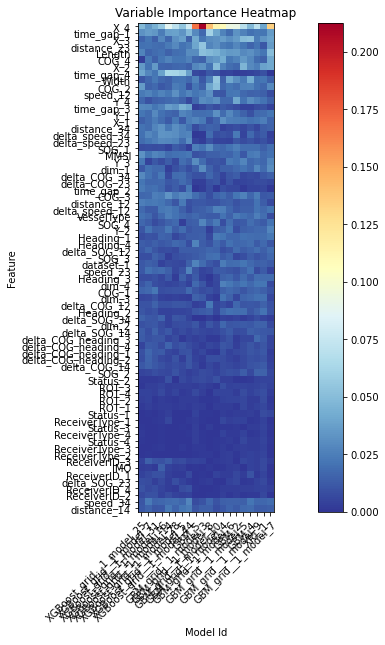

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

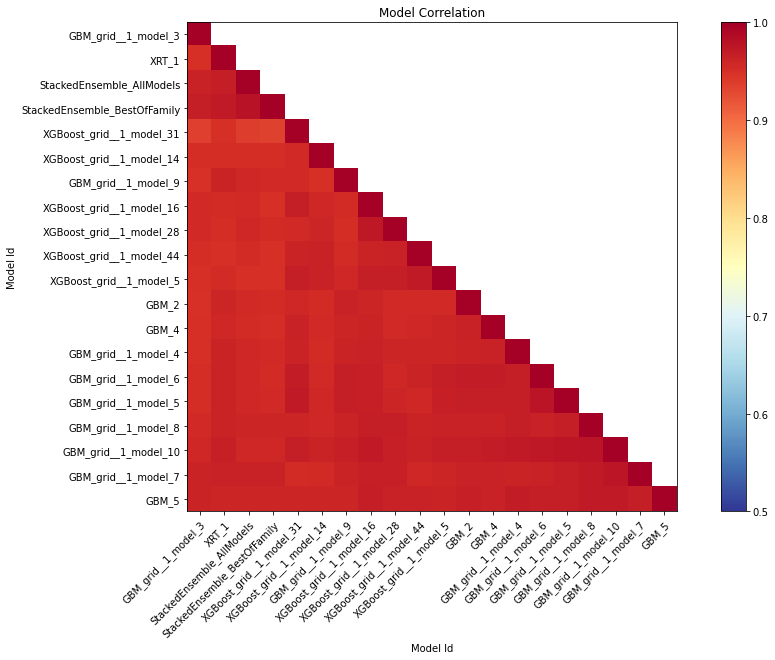

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

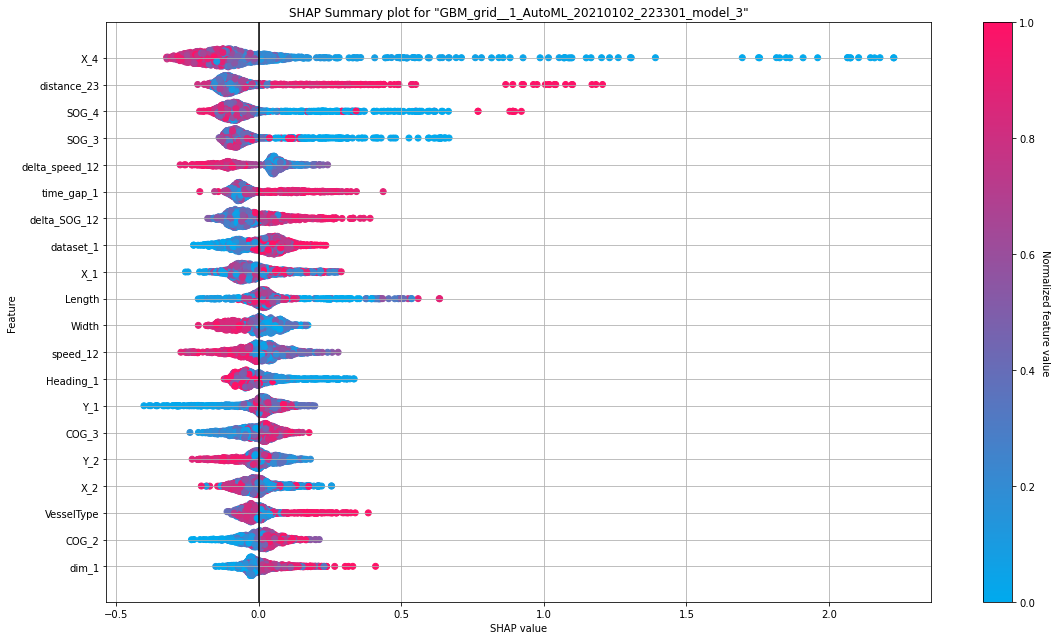

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

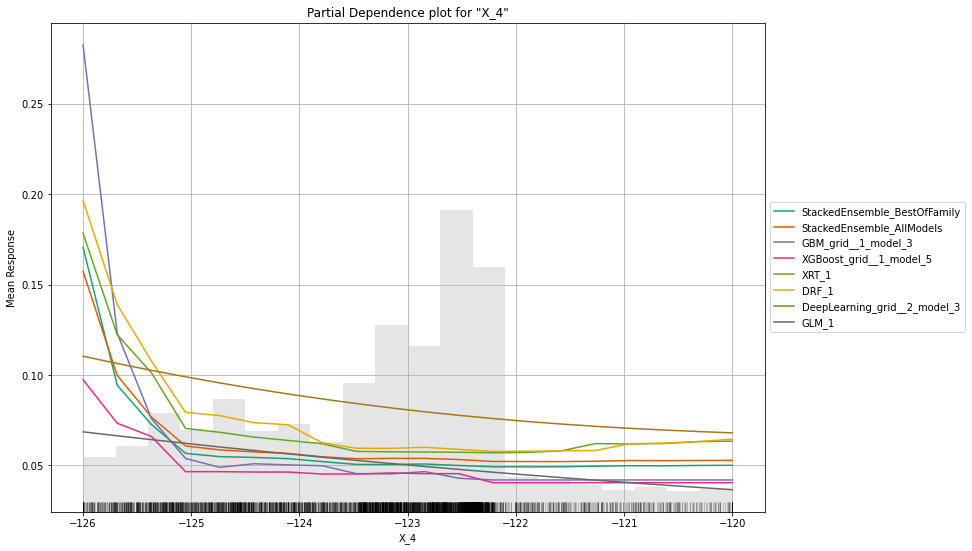

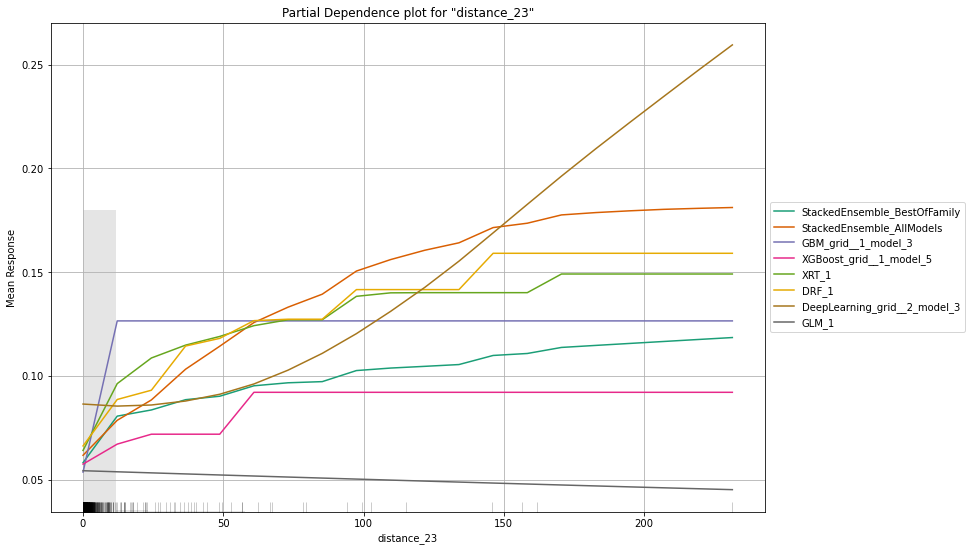

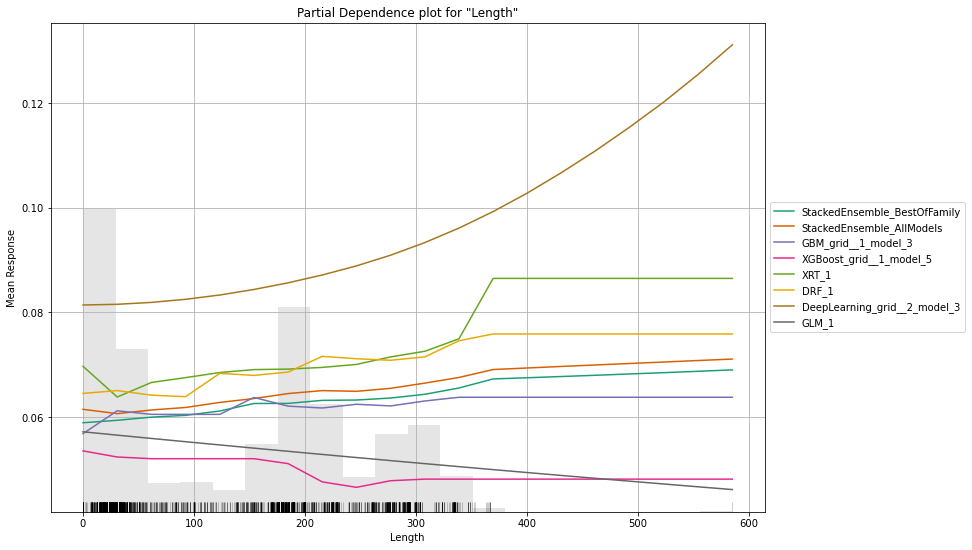

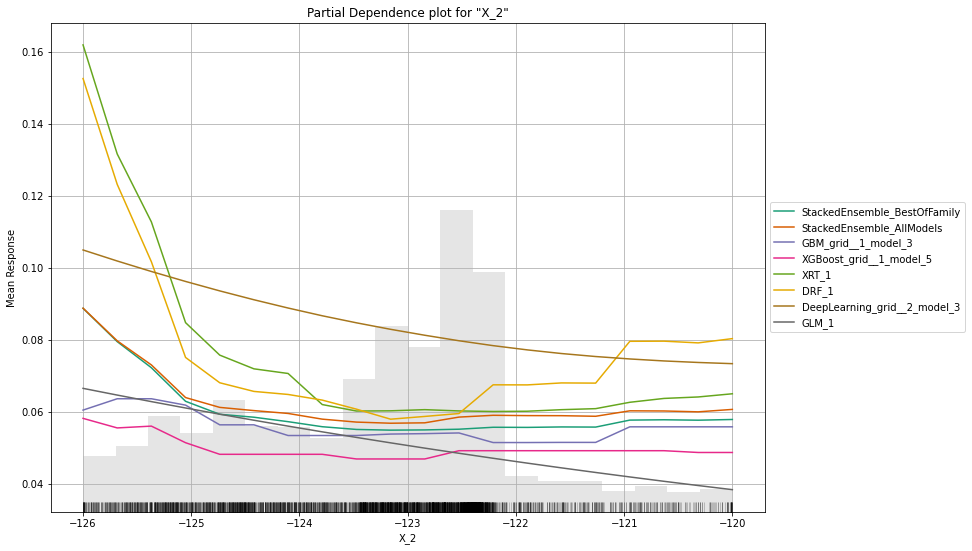

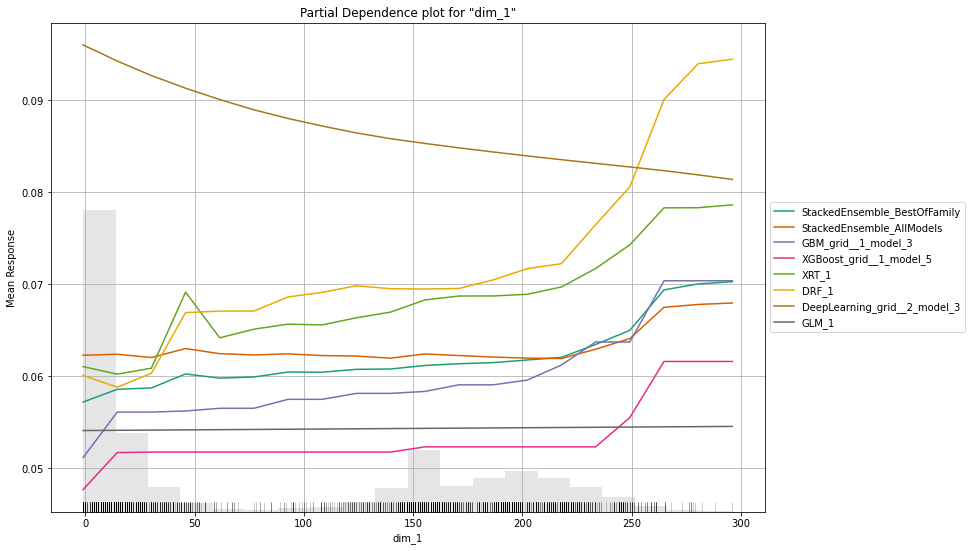

In [15]:
exa = aml.explain(test)